### Extracting data from the JSON files

In [1]:
import numpy as np
import json 
import pandas

In [7]:
DATA_SIZE = 1569264
SAMPLE_SIZE = 130000
TRAIN_SIZE = 25000
GOAL = 10000

In [8]:
business_ratings = { }
for line in open("data/yelp_academic_dataset_business.json", "r"):
    json_data = json.loads(line)
    business_ratings[json_data["business_id"]] = json_data["stars"]
#selected_businesses = set(np.random.choice(business_ratings.keys(), size = 2000, replace = False))
    
review_list = []

selected = set(np.random.choice(np.arange(DATA_SIZE), size=SAMPLE_SIZE, replace=False))
counters = {i: 0 for i in range(1, 6)}
for line_num, line in enumerate(open("data/yelp_academic_dataset_review.json", "r")):
    if line_num in selected:
        json_data = json.loads(line)
        stars = json_data["stars"]
        if (counters[stars] < GOAL):
            review_list.append([json_data["review_id"], json_data["stars"], json_data["text"], json_data["business_id"]])
            counters[stars] += 1
            
review_pd = pandas.DataFrame(review_list, columns = ["Review ID", "Stars", "Review Text", "Business ID"])

### Tokenizing the review text

In [10]:
import unicodedata
import sys
import unicodedata
tbl = dict.fromkeys(i for i in range(sys.maxunicode) if unicodedata.category(unichr(i)).startswith('P'))

def tokenize(text):
    return text.translate(tbl).lower().split()

review_pd["Tokenized Text"] = review_pd["Review Text"].apply(tokenize)

In [11]:
review_pd.shape

(50000, 5)

In [12]:
%matplotlib inline
review_pd.groupby("Stars").count()

,Review ID,Review Text,Business ID,Tokenized Text
Stars,,,,
1,10000,10000,10000,10000
2,10000,10000,10000,10000
3,10000,10000,10000,10000
4,10000,10000,10000,10000
5,10000,10000,10000,10000


In [14]:
review_pd.to_json('data/review_multinomial.json', orient="records")

### Manipulating data into LabeledSentences

In [ ]:
review_pd = pd.read_json('data/review_multinomial.json', orient="records")

In [36]:
from gensim.models.doc2vec import LabeledSentence
import numpy as np

class LabeledSentences:
    
    def __init__(self, series):
        self.series = series
        
    def __iter__(self):
        indexes = list(np.arange(len(self.series)))
        np.random.shuffle(indexes)
        for (index, wordlist) in self.series.iloc[indexes].iteritems():
        #for (index, wordlist) in self.series.iteritems():
            yield LabeledSentence(words = wordlist, tags = ['VEC_%s' % index])
            
sentences = LabeledSentences(review_pd["Tokenized Text"].copy())

### Learn vector representations for each word via Word2Vec

In [47]:
import multiprocessing
import gensim
from gensim.models import Doc2Vec

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be slow otherwise"
cores = multiprocessing.cpu_count()

model = Doc2Vec(dm = 1, dm_concat = 0, min_count = 1, window = 10, size = 100, sample = 1e-4, negative = 5, 
                workers = cores, alpha = 0.03, min_alpha = 0.03)
model.build_vocab(sentences)

### Learn vector representations for each review text via Doc2Vec

In [48]:
for epoch in range(10):
    model.train(sentences)
    #model.alpha -= 0.002
    #model.min_alpha = model.alpha

### Concatenate Review Rating with Vector

In [49]:
X, y = [], []

# train_indices = set(np.random.choice(np.arange(len(model.docvecs)), replace=False, size=TRAIN_SIZE))
for index in xrange(len(model.docvecs)):
    key = ("VEC_%s") % (index)
    
    X.append(model.docvecs[key])
    y.append(review_pd["Stars"][index])

    
X = np.array(X)
y = np.array(y)

In [24]:
X[y == 1, :].shape

(10000, 100)

In [50]:
train_Xs = []
test_Xs = []
train_ys = []
test_ys = []
for i in range(1, 6):
    X_class_i = X[y == i, :]
    y_class_i = y[y == i]
    train_Xs.append(X_class_i[:X_class_i.shape[0] // 2, :])
    test_Xs.append(X_class_i[X_class_i.shape[0] // 2:, :])
    train_ys.append(y_class_i[:y_class_i.shape[0] // 2])
    test_ys.append(y_class_i[y_class_i.shape[0] // 2:])
    
train_X = np.concatenate(train_Xs, axis=0)
train_y = np.concatenate(train_ys, axis=0)
test_X = np.concatenate(test_Xs, axis=0)
test_y = np.concatenate(test_ys, axis=0)

In [30]:
test_X.shape

(25000, 100)

(array([    0.,     0.,  5000.,     0.,  5000.,     0.,  5000.,     0.,
         5000.,     0.,  5000.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5]),
 <a list of 11 Patch objects>)

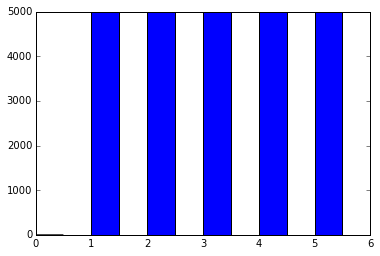

In [31]:
import matplotlib.pyplot as plt
plt.hist(train_y,bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5])

### Input data into Binomial Model

In [51]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met

logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
logreg.fit(train_X, train_y)

preds = logreg.predict(test_X)
print met.accuracy_score(test_y, preds)

0.5014


In [74]:
test_y_indicator = np.zeros((test_y.shape[0], 5))
preds_indicator = np.zeros((test_y.shape[0], 5))
for i in range(1, 6):
    test_y_indicator[:, i-1] = (test_y == i).astype(int)
    preds_indicator[:,i-1] = (preds == i).astype(int)

#test_y_indicator = np.concatenate(test_y_indicator, axis=1)
#preds_indicator = np.concatenate(preds_indicator, axis=1)

In [77]:
met.accuracy_score(test_y_indicator, preds_indicator)

0.50139999999999996

In [76]:
met.average_precision_score(test_y_indicator, preds_indicator)

0.54915742052014749

### Param tuning

In [78]:
s = 20
step = 20


while s < 160:
    print "training: size = %s" % s 
    cores = multiprocessing.cpu_count()

    model = Doc2Vec(min_count = 1, window = 10, size = s, sample = 1e-4, negative = 5, 
                    workers = cores, alpha = 0.025, min_alpha = 0.025)
    model.build_vocab(sentences)

    for epoch in range(10):
        model.train(sentences)
        #model.alpha -= 0.002
        #model.min_alpha = model.alpha
    
    X, y = [], []

    # train_indices = set(np.random.choice(np.arange(len(model.docvecs)), replace=False, size=TRAIN_SIZE))
    for index in xrange(len(model.docvecs)):
        key = ("VEC_%s") % (index)

        X.append(model.docvecs[key])
        y.append(review_pd["Stars"][index])


    X = np.array(X)
    y = np.array(y)
    
    train_Xs = []
    test_Xs = []
    train_ys = []
    test_ys = []
    for i in range(1, 6):
        X_class_i = X[y == i, :]
        y_class_i = y[y == i]
        train_Xs.append(X_class_i[:X_class_i.shape[0] // 2, :])
        test_Xs.append(X_class_i[X_class_i.shape[0] // 2:, :])
        train_ys.append(y_class_i[:y_class_i.shape[0] // 2])
        test_ys.append(y_class_i[y_class_i.shape[0] // 2:])

    train_X = np.concatenate(train_Xs, axis=0)
    train_y = np.concatenate(train_ys, axis=0)
    test_X = np.concatenate(test_Xs, axis=0)
    test_y = np.concatenate(test_ys, axis=0)
    
    logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
    logreg.fit(train_X, train_y)

    preds = logreg.predict(test_X)
    
    test_y_indicator = np.zeros((test_y.shape[0], 5))
    preds_indicator = np.zeros((test_y.shape[0], 5))
    for i in range(1, 6):
        test_y_indicator[:, i-1] = (test_y == i).astype(int)
        preds_indicator[:,i-1] = (preds == i).astype(int)
    
    print "accuracy: %s" % met.accuracy_score(test_y_indicator, preds_indicator)  
    print "average precision: %s" % met.average_precision_score(test_y_indicator, preds_indicator)

    s += step
    


training: size = 20
accuracy: 0.4602
average precision: 0.509918532548
training: size = 40
accuracy: 0.4786
average precision: 0.527859685395
training: size = 60
accuracy: 0.49448
average precision: 0.542344882695
training: size = 80
accuracy: 0.499
average precision: 0.546566394801
training: size = 100
accuracy: 0.49824
average precision: 0.545698931296
training: size = 120
accuracy: 0.50008
average precision: 0.547482420424
training: size = 140
accuracy: 0.50824
average precision: 0.554840165505
